# OFFLINE PATH PLANNING OPTIMISATION
This notebook elaborates the **testing** of an offline path planning optimisation pipeline to generate a safe and feasible reference path for a ego vehicle. The pipeline takes a set of coarsely placed waypoints and adjusts their localisation so as to comply with certain **path curvature** constraints in view of the vehicle's size and steering capability. The adjusted waypoints should be as close as possible to the original waypoints without violating the curvature constraints.

## Setup
Due to the way Python and Windows handle concurrency, it is less efficient to run this notebook on a Windows operating system.

### Installation
Before beginning, it is important to install all the dependencies to run all cells in this notebook. You can do that by running the following cell after converting the Markdown into code.

!pip install -r requirements.txt

### Imports

In [46]:
import time as t
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.optimize import minimize

### Importing Waypoints

In [47]:
dir_path = 'ngeeann.csv'
df = pd.read_csv(dir_path)
wx = df['x'].values.tolist()
wy = df['y'].values.tolist()

if len(wx) != len(wy):
    raise Exception("Waypoints are not valid. Length of axes do not match.")

else:
    wn = len(wx)
    print("Number of generated waypoints: {}".format(wn))

Number of generated waypoints: 117


## Approach 4: Controlled Unconstrained Quadratic Path Optimisation
In this approach, no seeding path is generated and optimisation is done directly on the waypoints. Additionally, curb information is given to ensure that the resultant path does not intersect with the curb.

### Importing Curb Information

In [48]:
curb_num = 9
curbs_x = []
curbs_y = []

dir_path = 'curb.csv'
df = pd.read_csv(dir_path, delimiter=';')
curb_group = df.groupby(df.shapeid)

for curb in range(0, curb_num):
    if curb in curb_group.groups.keys():
        curb_x = curb_group.get_group(curb)['x'].values.tolist()
        curb_y = curb_group.get_group(curb)['y'].values.tolist()
        curbs_x.append(curb_x)
        curbs_y.append(curb_y)
        print("Key found")

    else:
        print("Key not found (no. {})".format(curb))

Key found
Key found
Key found
Key found
Key found
Key found
Key not found (no. 6)
Key found
Key found


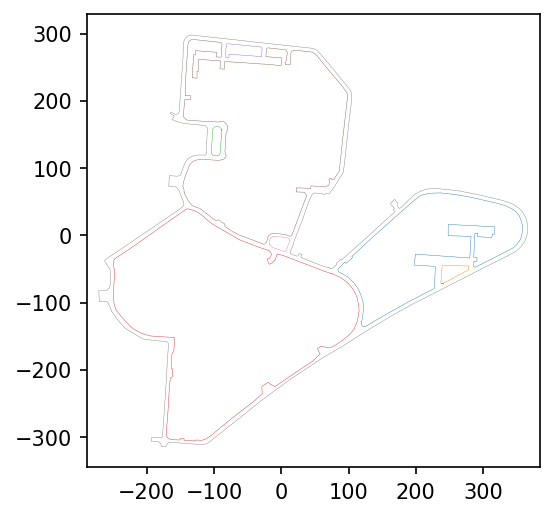

In [49]:
%matplotlib inline

fig = plt.figure(dpi=150)
ax = plt.axes()
ax.set_aspect('equal')
ax.set_box_aspect(1)

for n in range(0, max(len(curbs_x), len(curbs_y))):
    ax.plot(curbs_x[n], curbs_y[n], linewidth=0.2)

plt.show()

### Cubic Spline Sampling
Although no seeding path will be generated, the cubic spline library is still required to meet the path resolution target.

In [50]:
from bisect import bisect

class Spline:

    def __init__(self, x, y):
        
        self.x = x
        self.y = y

        self.a = y
        self.b = []
        self.d = []

        dim_size = max(len(x), len(y))
        h = np.diff(x)

        A = self.matrixA(h, dim_size)
        B = self.matrixB(h, dim_size)
        self.c = np.linalg.solve(A, B)

        for i in range(dim_size - 1):
            self.b.append((self.a[i + 1] - self.a[i])/h[i] - h[i]*(self.c[i + 1] + 2.0*self.c[i]) / 3.0)
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))

    def matrixA(self, h, size):
        
        A = np.zeros((size, size))
        A[0, 0] = 1.0

        for i in range(size - 1):
            if i != (size - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[size - 1, size - 2] = 0.0
        A[size - 1, size - 1] = 1.0

        return A

    def matrixB(self, h, size):
        
        B = np.zeros(size)

        for i in range(size - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
            
        return B

    def solve_function(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = self.a[i] + self.b[i]*deltax + self.c[i]*deltax**2.0 + self.d[i]*deltax**3.0

            return result

    def solve_1st_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = self.b[i] + 2.0*self.c[i]*deltax + 3.0*self.d[i]*deltax**2.0

            return result

    def solve_2nd_derivative(self, x):
        
        if x < self.x[0]:
            return None

        elif x > self.x[-1]:
            return None

        else:
            i = self.search_index(x)
            deltax = x - self.x[i]
            result = 2.0*self.c[i] + 6.0*self.d[i] * deltax

            return result

    def search_index(self, x):

        i = bisect(self.x, x) - 1

        return i

class Spline2D:

    def __init__(self, x, y):

        self.ds = None

        self.s = self.calculate_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def calculate_s(self, x, y):
        
        deltax = np.diff(x)
        deltay = np.diff(y)
        self.ds = np.hypot(deltax, deltay)

        s = [0]
        s.extend(np.cumsum(self.ds))

        return s

    def calculate_position(self, s):
        
        x = self.sx.solve_function(s)
        y = self.sy.solve_function(s)

        return x, y

    def calculate_yaw(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        yaw = np.arctan2(dy, dx)

        return yaw

    def calculate_curvature(self, s):
        
        dx = self.sx.solve_1st_derivative(s)
        ddx = self.sx.solve_2nd_derivative(s)
        dy = self.sy.solve_1st_derivative(s)
        ddy = self.sy.solve_2nd_derivative(s)

        k = (ddy*dx - ddx*dy) / ((dx**2 + dy**2)**(3 / 2))

        return k

def generate_cubic_path(x, y, ds=0.05):

    sp2d = Spline2D(x, y)
    s = np.arange(0, sp2d.s[-1], ds)

    px = []
    py = []
    pyaw = []
    pk = []

    for i in s:
        ix, iy = sp2d.calculate_position(i)
        px.append(ix)
        py.append(iy)
        pyaw.append(sp2d.calculate_yaw(i))
        pk.append(sp2d.calculate_curvature(i))

    return px, py, pyaw, pk

### Calculate Curvature
The following functions allow us to calculate path curvature and rate for visualisation and the objective function. There are two methods to approximate discrete path curvature. According to the paper, the linear distance $\Delta{s_i}$ between two points must be computed as,
$$
\Delta{s_i} = ||P_{i+1} - P_i||,
$$
where P_i is a point on the path and P_{i+1} is the following point. Secondly, the unit heading vector $u_i$ is calculated as,
$$
u_i = \frac{(P_{i+1} - P_i)}{\Delta{s_i}}.
$$
Finally, the path curvature $k_i$ can be calculated as the change of unit heading vector which is represented in the following equation,
$$
k_i = \frac{(u_{i+1} - u_i)}{\Delta{s_i}}.
$$
However, this method is unsuitable for visualisation as the polarity of the curvature is lost. Hence, a different [approximation method](https://www.math24.net/curvature-radius) is used. This is expressed in the following equation,
$$
k = \frac{|x'y'' - y'x''|}{(x'^2 + y'^2)^{\frac{3}{2}}}
$$

In [51]:
def solve_1st_derivative(x, y):

    dx = []
    dy = []

    for i in range(0, max(len(x), len(y)) - 1):
        dx.append(x[i+1] - x[i])
        dy.append(y[i+1] - y[i])

    dx.append(dx[-1])
    dy.append(dy[-1])

    return dx, dy

def calculate_curvature(x, y):

    dx, dy = solve_1st_derivative(x, y)
    ddx, ddy = solve_1st_derivative(dx, dy)

    k = []
    
    for i in range(0, max(len(x), len(y))):
        k.append((ddy[i]*dx[i] - ddx[i]*dy[i]) / ((dx[i]*dx[i] + dy[i]*dy[i])**(3/2)))

    return k
    
def calculate_curvature_vector(x, y):

    delta_s = []
    u_i = []
    k_i = []

    for i in range(0, max(len(x), len(y)) - 1):
        p_current = np.array([x[i], y[i]])
        p_next = np.array([x[i + 1], y[i + 1]])
        dp = p_next - p_current

        delta_s.append(np.hypot(dp[0], dp[1]))
        u_i.append(dp / delta_s[i])

    delta_s.append(delta_s[-1])
    u_i.append(u_i[-1])

    for i in range(0, max(len(x), len(y)) - 1):
        du = u_i[i + 1] - u_i[i]
        abs_du = np.hypot(du[0], du[1])
        k_i.append(abs_du/delta_s[i])

    k_i.append(k_i[-1])

    return k_i

### Calculate Yaw
To create the lateral constraints, the yaw of the waypoints must be calculated.

In [52]:
def calculate_yaw(x, y):

    dx, dy = solve_1st_derivative(x, y)

    yaw = []

    yaw.append(m.atan2(dy[0], dx[0]))

    for i in range(1, max(len(x), len(y)) - 1):
        d0 = np.array([dx[i], dy[i]])
        d0_hat = d0/np.linalg.norm(d0)

        d1 = np.array([dx[i-1], dy[i-1]])
        d1_hat = d1/np.linalg.norm(d1)

        d_bisect = d0_hat + d1_hat
        
        yaw.append(m.atan2(d_bisect[1], d_bisect[0]))

    yaw.append(m.atan2(dy[-1], dx[-1]))
        
    return yaw

### Visualising Waypoints

In [53]:
wyaw = calculate_yaw(wx, wy)
wk = calculate_curvature(wx, wy)

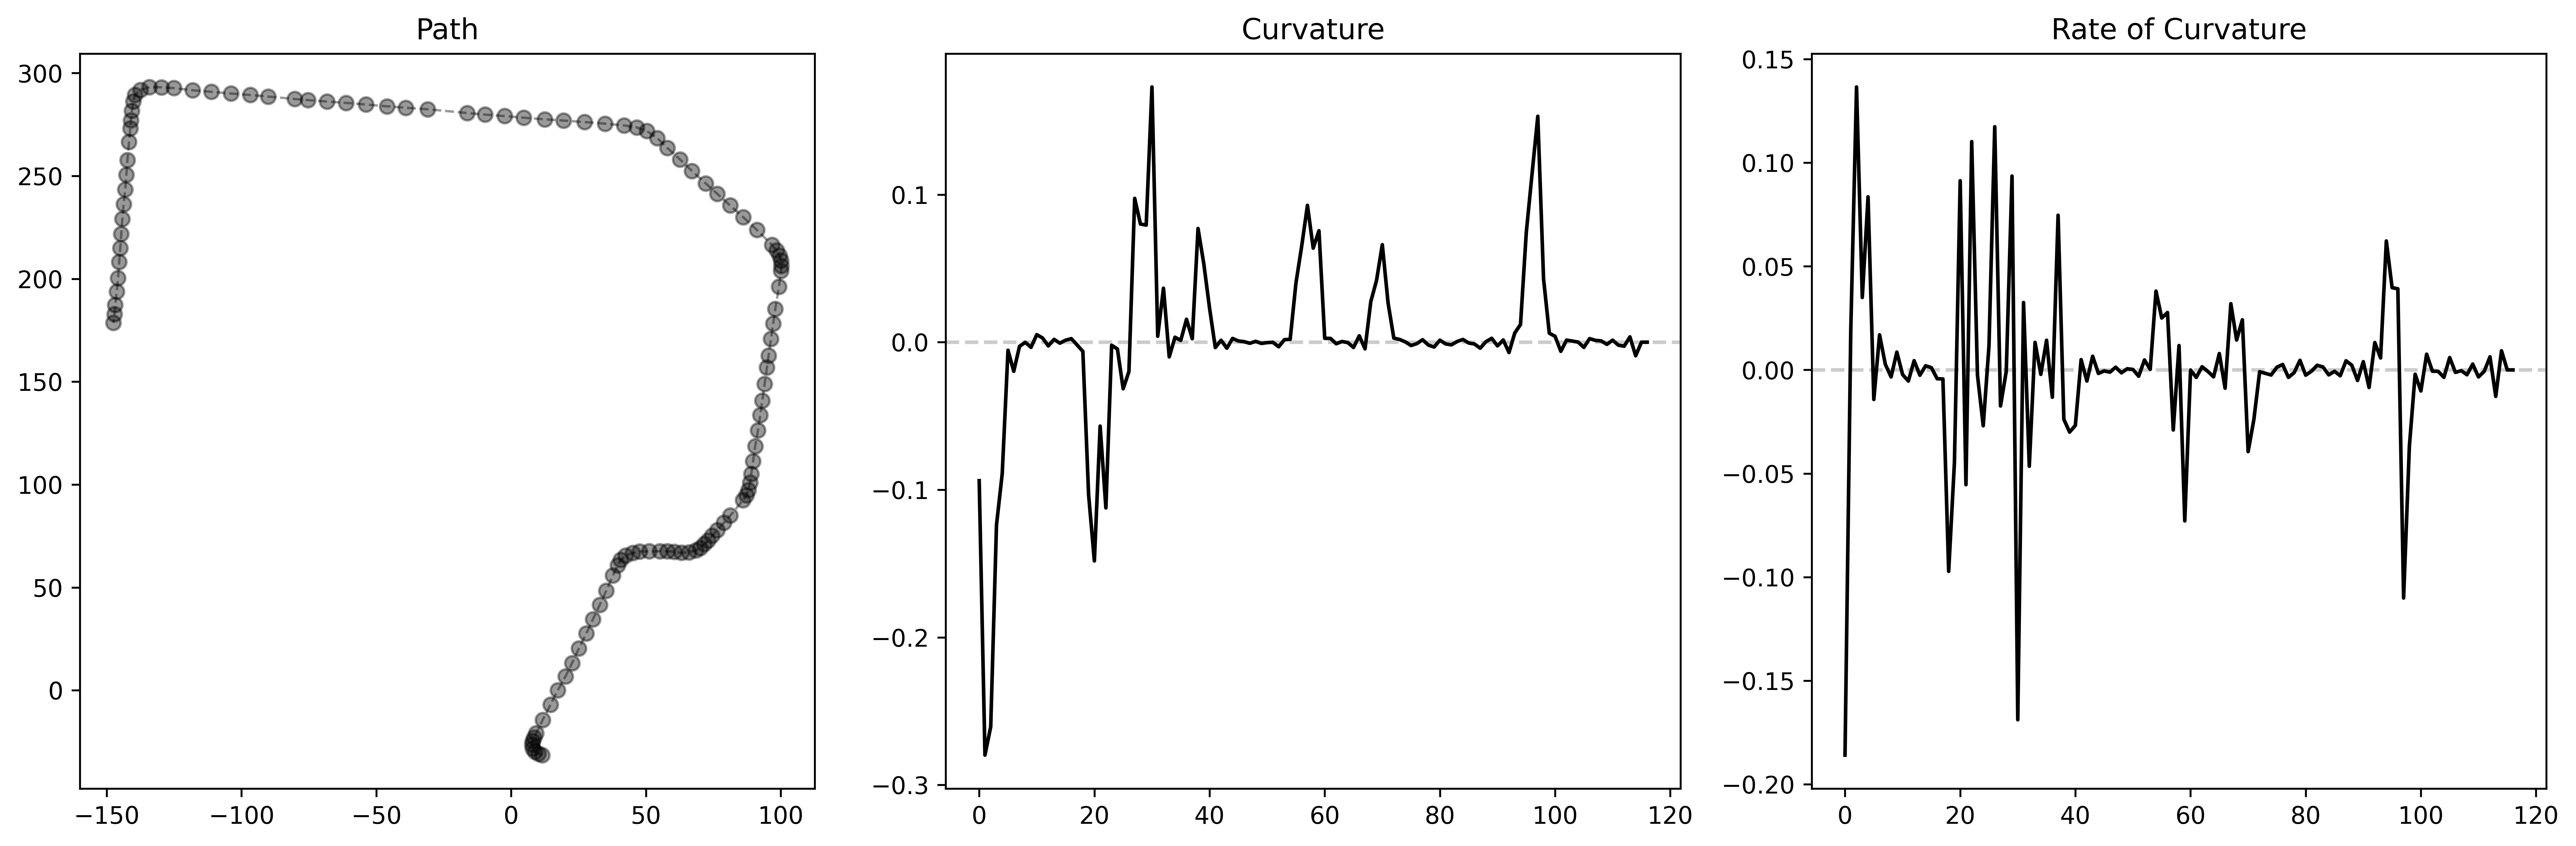

In [54]:
%matplotlib inline

dwk, _ = solve_1st_derivative(wk, wk)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

ax[0].set_box_aspect(1)
ax[0].set_title('Path')
ax[0].plot(wx, wy, '--ok', linewidth=1, alpha=0.4)

ax[1].set_box_aspect(1)
ax[1].set_title('Curvature')
ax[1].plot(wk, color='k')
ax[1].axhline(0, linestyle='--', color='k', alpha=0.2)

ax[2].set_box_aspect(1)
ax[2].set_title('Rate of Curvature')
ax[2].plot(dwk, color='k')
ax[2].axhline(0, linestyle='--', color='k', alpha=0.2)

plt.tight_layout()
plt.show()

### Generating a Comparison Path
A path is with similar resolution to the optimised path is created for comparison.

In [55]:
cx, cy, _, ck = generate_cubic_path(wx, wy, 1.0)
dck, _ = solve_1st_derivative(ck, ck)

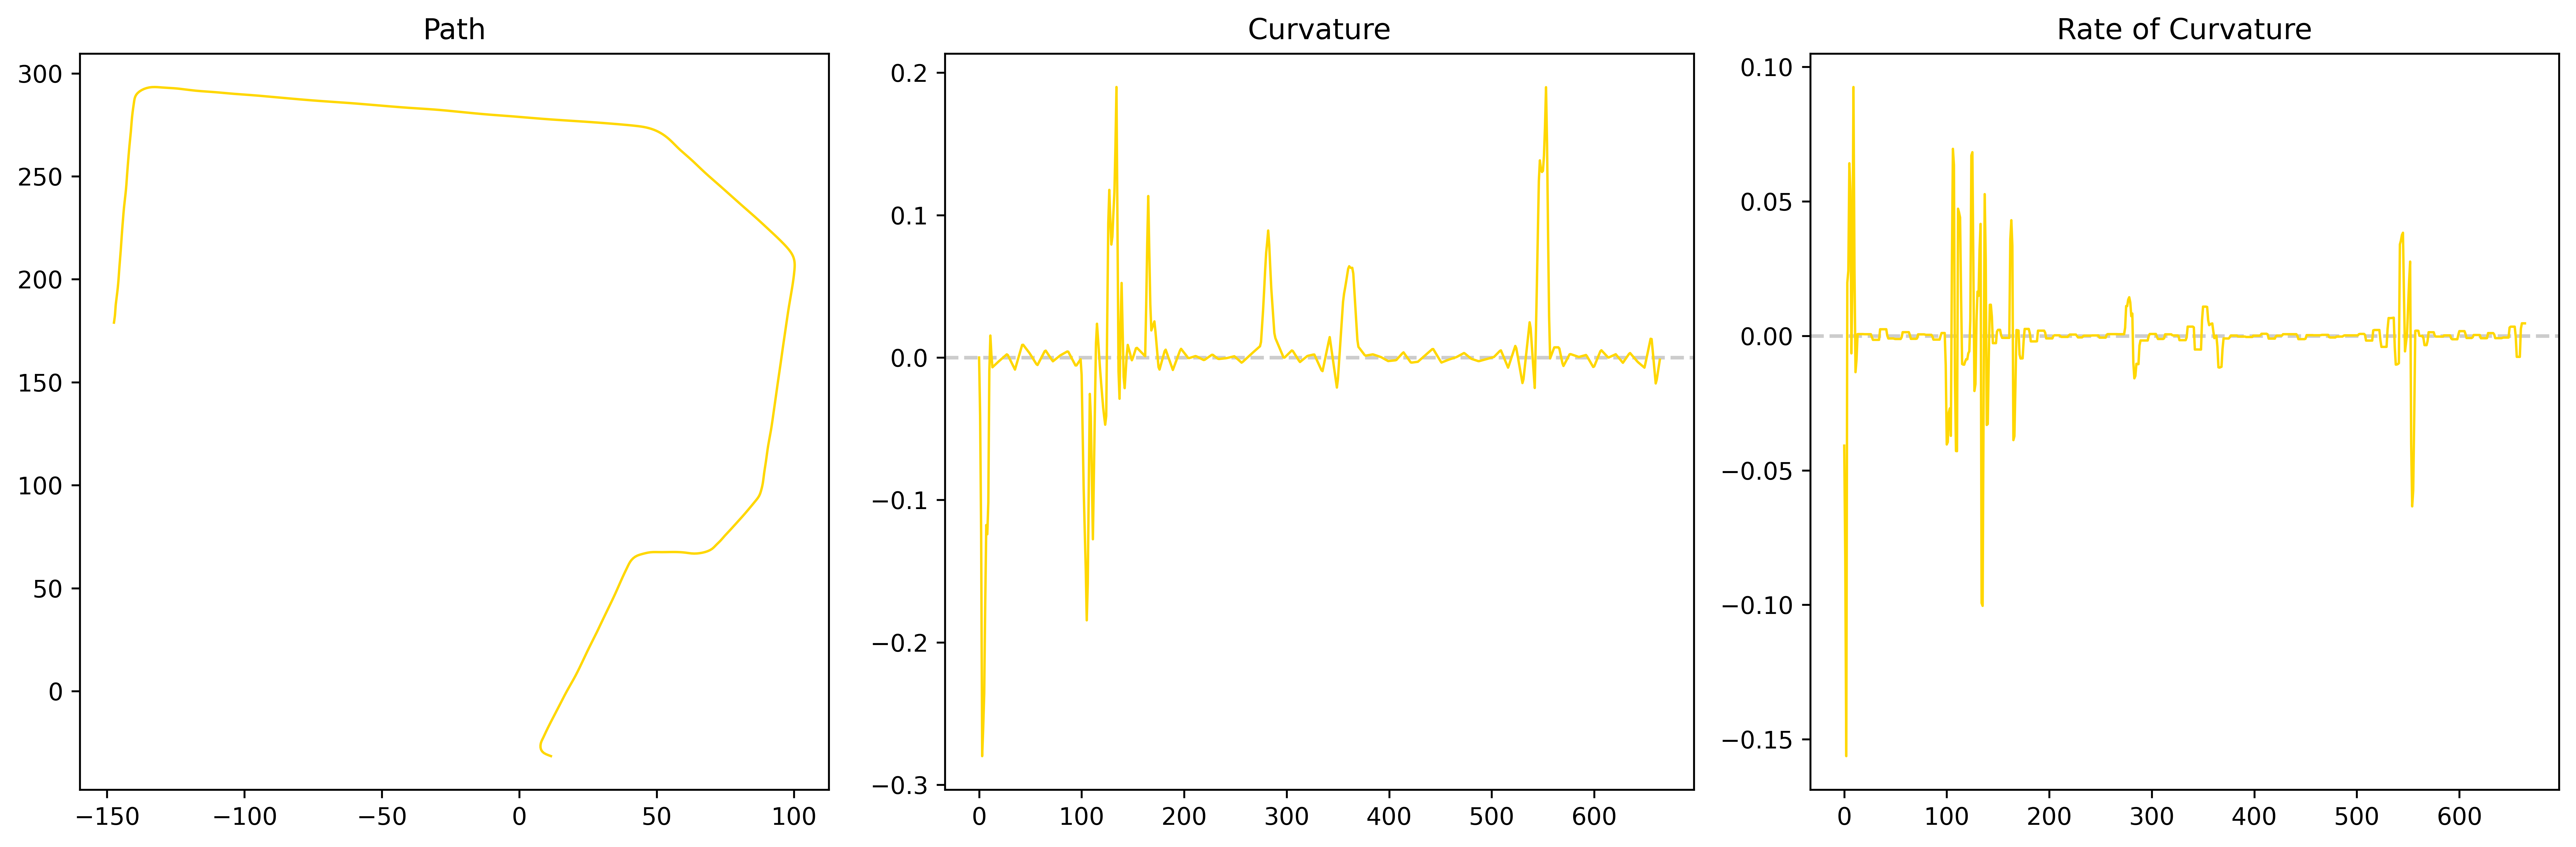

In [56]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

ax[0].set_title('Path')
ax[0].plot(cx, cy, color='gold', linewidth=1)

ax[1].set_title('Curvature')
ax[1].axhline(0, linestyle='--', color='k', alpha=0.2)
ax[1].plot(ck, color='gold', linewidth=1)

ax[2].set_title('Rate of Curvature')
ax[2].axhline(0, linestyle='--', color='k', alpha=0.2)
ax[2].plot(dck, color='gold', linewidth=1)

plt.tight_layout()
plt.show()

### Define the boundary
Previously, we assumed that the original path would be located in the middle of the road. However, in reality, roads are split into multiple lanes, usually into the left and right lanes. Ideally, the resultant path should maintain a safe distance away from the curb at all times. Thus, our boundary equation can be expressed as,
$$
o_i \in \min(\phi_{dist},\ \Delta_{max}),
$$
where $\phi_{dist}$ is the allowable distance to a curb and $\Delta_{max}$ is the maximum lateral deviation. We calculate $\phi_{dist}$ with the following expression,
$$
\phi_{dist} =
\begin{cases}
\lambda_{curb} - \alpha_{thresh}, & \mbox{if } \ \lambda_{curb} > \alpha_{thresh} \\
0, & \text{otherwise}
\end{cases},
$$
where $\alpha_{thresh}$ is the minimum allowable distance to the curb based on safety guidelines and $\lambda_{curb}$ is the shortest distance from the path to the curb. Ideally, the distance should be measured orthogonally from the path to the curb. For clarity, $\alpha_{thresh}$ is expressed as,
$$
\alpha_{thresh} = \frac{w_{vehicle}}{2} + \kappa,
$$
where $w_{vehicle}$ is the vehicle's width and $\kappa$ is a arbitrary threshold set by the user.

In [57]:
def calculate_shortest_distance(x, y, curb):

    dx = [x - icx for icx in curb[0]]
    dy = [y - icy for icy in curb[1]] 

    d = np.hypot(dx, dy)
    return np.min(d), np.argmin(d)


In [58]:
lx = []
ly = []
rx = []
ry = []
left_lateral_offset = []
right_lateral_offset = []
bound = []

vehicle_width = 2.0
k = 0.5
max_deviation = 0.5
min_dist = vehicle_width/2 + k
curb_concat = [np.concatenate(curbs_x, axis=None), np.concatenate(curbs_y, axis=None)]

for i in range(0, len(wyaw)):
    closest_curb_dist, closest_curb = calculate_shortest_distance(wx[i], wy[i], curb_concat)

    if closest_curb_dist > min_dist:
        allowable_dist = closest_curb_dist - min_dist

        if allowable_dist < max_deviation:
            path_vector = [-np.cos(wyaw[i] + np.pi/2), -np.sin(wyaw[i] + np.pi/2)]
            crosstrack_error = np.dot([curb_concat[0][closest_curb], curb_concat[1][closest_curb]], path_vector)

            if crosstrack_error > 0:
                # Curb is on the left
                left_lateral_offset.append(allowable_dist)
                right_lateral_offset.append(max_deviation)

            elif crosstrack_error < 0:
                # Curb is on the right
                left_lateral_offset.append(max_deviation)
                right_lateral_offset.append(allowable_dist)

        else:
            left_lateral_offset.append(max_deviation)
            right_lateral_offset.append(max_deviation)
    
    else:
        path_vector = [-np.cos(wyaw[i] + np.pi/2), -np.sin(wyaw[i] + np.pi/2)]
        crosstrack_error = np.dot([curb_concat[0][closest_curb], curb_concat[1][closest_curb]], path_vector)

        if crosstrack_error > 0:
            # Curb is on the left
            left_lateral_offset.append(0)
            right_lateral_offset.append(max_deviation)

        elif crosstrack_error < 0:
            # Curb is on the right
            left_lateral_offset.append(max_deviation)
            right_lateral_offset.append(0)

        else:
            allowable_dist = 0.0001
            left_lateral_offset.append(min(allowable_dist, max_deviation))
            right_lateral_offset.append(min(allowable_dist, max_deviation))

for i in range(0, len(wyaw)):
    lx.append(wx[i] - left_lateral_offset[i]*np.sin(wyaw[i]))
    ly.append(wy[i] + left_lateral_offset[i]*np.cos(wyaw[i]))
    rx.append(wx[i] + right_lateral_offset[i]*np.sin(wyaw[i]))
    ry.append(wy[i] - right_lateral_offset[i]*np.cos(wyaw[i]))

for i in range(0, len(wyaw)):
    bound.append((-left_lateral_offset[i], right_lateral_offset[i]))

bounds = tuple(bound)
print("Length of bounds: {}".format(len(bounds)))

Length of bounds: 117


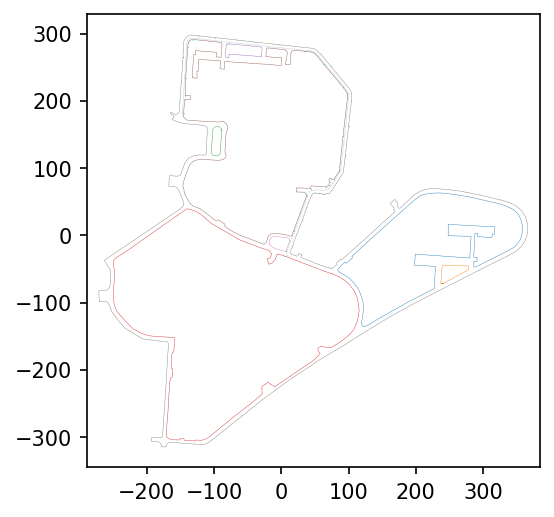

In [59]:
%matplotlib inline

fig = plt.figure(dpi=150)
ax = plt.axes()
ax.set_aspect('equal')
ax.set_box_aspect(1)

for n in range(0, max(len(curbs_x), len(curbs_y))):
    ax.plot(curbs_x[n], curbs_y[n], linewidth=0.2)

ax.plot(wx, wy, linewidth=0.05)
ax.plot(lx, ly, '--b', alpha=0.5, linewidth=0.05)
ax.plot(rx, ry, '--b', alpha=0.5, linewidth=0.05)
ax.plot(curb_concat[0][test], curb_concat[1][test], '.', markersize=0.5, markeredgewidth=0.0)

plt.show()

### Define the Objective Function
The objective function remains as,
$$
\min(\sum^{N-1}_{i=0}{w_k \cdot |k_i^2|}).
$$
Increasing the value of $w_k$ has shown to increase path curvature. Unfortunately, there are diminishing returns at very high values. Furthermore, calculating the spline within the objective function improves the predictability and accuracy of the resultant path.

In [60]:
def objective_fcn(lateral_offset):

    wk = 50
    
    wox = wx.copy()
    woy = wy.copy()

    for n in range(0, len(wyaw)):
        wox[n] += lateral_offset[n]*np.sin(wyaw[n])
        woy[n] -= lateral_offset[n]*np.cos(wyaw[n])

    _, _, _, wok = generate_cubic_path(wox, woy, 1.0)

    curvature_cost = wk * np.mean(np.square(wok))

    return curvature_cost

### Define the Initial Values

In [61]:
guess = np.zeros(len(wyaw))
print("Cost: {}".format(objective_fcn(guess)))

Cost: 0.06925217245732493


### Optimise
> WARNING: If speed is of importance, `visualise` should be set to `False`, as the animation will massively slow down optimisation performance.
>

In [62]:
import os

visualise = False

start = t.time()

if visualise:

    from IPython.display import display, clear_output
    fig_cb = plt.figure(dpi=150)
    Nfeval = 0

    def callback(Xi):

        global Nfeval

        ox = wx.copy()
        oy = wy.copy()

        for n in range(0, len(wyaw)):
            wox[n] += Xi[n]*np.sin(wyaw[n])
            woy[n] -= Xi[n]*np.cos(wyaw[n])

        ox, oy, _, ok = generate_cubic_path(wox, woy, 1.0)
        cum_ok = np.mean(np.absolute(ok))

        plt.clf()
        plt.axes().set_box_aspect(1)
        plt.plot(lx, ly, '--b', alpha=0.5, linewidth=1)
        plt.plot(rx, ry, '--b', alpha=0.5, linewidth=1)
        plt.plot(road_lx, road_ly, '-k', linewidth=1)
        plt.plot(road_rx, road_ry, '-k', linewidth=1)
        plt.plot(px, py, '--', color='gold', linewidth=1)
        plt.plot(ox, oy, '-', color='magenta')
        plt.title("{} iterations".format(Nfeval), loc='right')
        plt.xlabel("Cumulative Curvature: {}".format(np.around(cum_ok, 4)))
        Nfeval += 1
        clear_output(wait=True)
        display(fig_cb)

    if os.name != 'nt':
        from optimparallel import minimize_parallel

        print("Parallel optimisation is possible. Beginning optimisation..")

        %time result = minimize_parallel(objective_fcn, guess, bounds=bounds, options={'maxfun': 1000000}, callback=callback)

    else:
        print("User is on a Windows system. Parallel optimisation is not possible. Defaulting..")

        %time result = minimize(objective_fcn, guess, bounds=bounds, options={'maxfun': 1000000}, callback=callback)

else:
    if os.name != 'nt':
        from optimparallel import minimize_parallel

        print("Parallel optimisation is possible. Beginning optimisation..")

        %time result = minimize_parallel(objective_fcn, guess, bounds=bounds, options={'maxfun': 1000000})

    else:
        print("User is on a Windows system. Parallel optimisation is not possible. Defaulting..")

        %time result = minimize(objective_fcn, guess, bounds=bounds, options={'maxfun': 1000000})

end = t.time()
unmodified_time = end - start

print("Message: {}".format(result.message))
print("Success: {}".format(result.success))
print("Evaluations: {}".format(result.nfev))
print("Iterations: {}".format(result.nit))

User is on a Windows system. Parallel optimisation is not possible. Defaulting..
Wall time: 10min 9s
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Success: True
Evaluations: 42480
Iterations: 342


In [71]:
if result.success:
    wox = wx.copy()
    woy = wy.copy()

    for n in range(0, len(wyaw)):
        wox[n] += result.x[n]*np.sin(wyaw[n])
        woy[n] -= result.x[n]*np.cos(wyaw[n])

    ox, oy, _, ok = generate_cubic_path(wox, woy, 1.0)

else:
    raise Exception("Optimisation failed.")

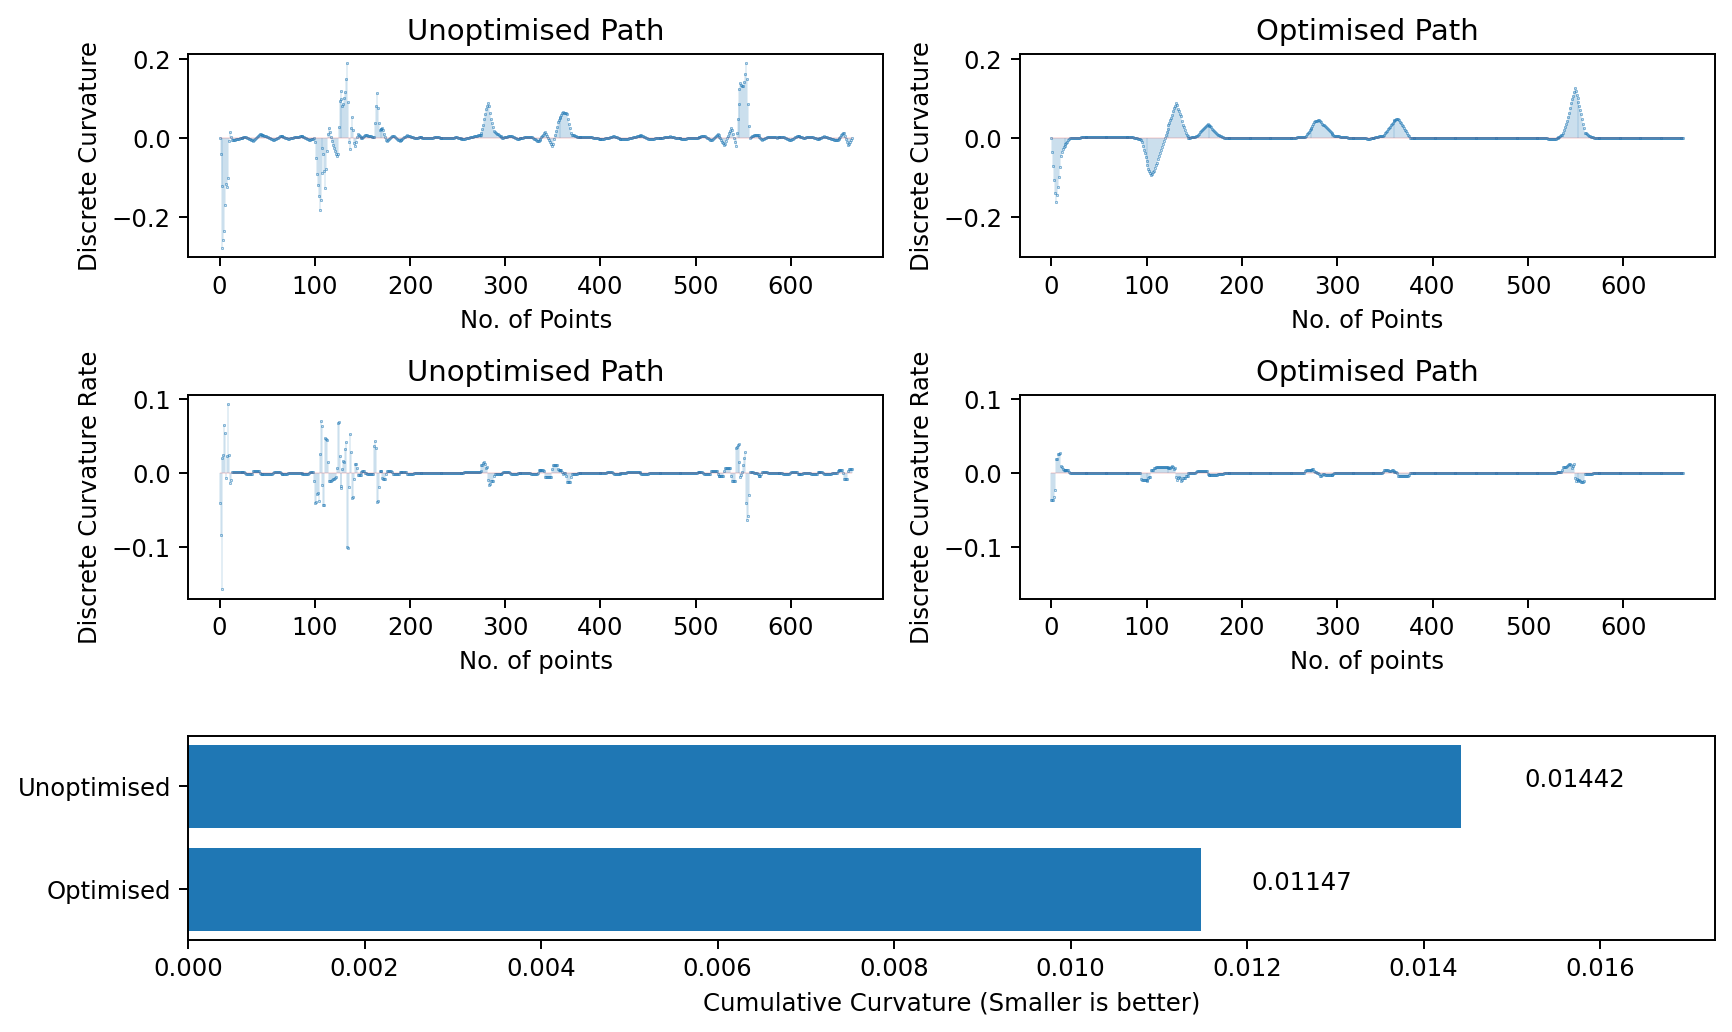

In [72]:
%matplotlib inline

dok, _ = solve_1st_derivative(ok, ok)

cum_ok = np.mean(np.absolute(ok))
cum_ck = np.mean(np.absolute(ck))

category = ['Optimised', 'Unoptimised']
curvature = [cum_ok, cum_ck]

gs = gridspec.GridSpec(3, 2)
fig = plt.figure(dpi=175, figsize=(10, 6))

ax1 = fig.add_subplot(gs[2, :]) 
ax1.barh(category, curvature)
ax1.set_xlabel('Cumulative Curvature (Smaller is better)')
ax1.set_xlim((0, max(curvature) + (0.2*max(curvature))))

for index, value in enumerate(curvature):
    ax1.text(value + (0.05*value), index, str(np.around(value, 5)))

ax2 = fig.add_subplot(gs[0, 0])
marker1, stem1, base1, = ax2.stem(range(0, len(ck)), ck)
ax2.set_ylabel('Discrete Curvature')
ax2.set_xlabel('No. of Points')
ax2.set_title('Unoptimised Path')

ax3 = fig.add_subplot(gs[0, 1], sharey=ax2)
marker2, stem2, base2, = ax3.stem(range(0, len(ok)), ok)
ax3.set_ylabel('Discrete Curvature')
ax3.set_xlabel('No. of Points')
ax3.set_title('Optimised Path')

ax4 = fig.add_subplot(gs[1, 0])
marker3, stem3, base3, = ax4.stem(range(0, len(dck)), dck)
ax4.set_ylabel('Discrete Curvature Rate')
ax4.set_xlabel('No. of points')
ax4.set_title('Unoptimised Path')

ax5 = fig.add_subplot(gs[1, 1], sharey=ax4)
marker4, stem4, base4, = ax5.stem(range(0, len(dok)), dok)
ax5.set_ylabel('Discrete Curvature Rate')
ax5.set_xlabel('No. of points')
ax5.set_title('Optimised Path')

plt.setp(stem1, 'linewidth', 0.1)
plt.setp(marker1, 'markersize', 0.2)
plt.setp(base1, 'linewidth', 0.1)
plt.setp(stem2, 'linewidth', 0.1)
plt.setp(marker2, 'markersize', 0.2)
plt.setp(base2, 'linewidth', 0.1)
plt.setp(stem3, 'linewidth', 0.1)
plt.setp(marker3, 'markersize', 0.2)
plt.setp(base3, 'linewidth', 0.1)
plt.setp(stem4, 'linewidth', 0.1)
plt.setp(marker4, 'markersize', 0.2)
plt.setp(base4, 'linewidth', 0.1)

plt.tight_layout()
plt.show()

In [73]:
%matplotlib qt

plt.figure()
ax = plt.axes() 
ax.set_aspect('equal')

for n in range(0, max(len(curbs_x), len(curbs_y))):
    ax.plot(curbs_x[n], curbs_y[n], linewidth=0.2)
    
ax.plot(wx, wy, 'ok', alpha=0.4, label='Waypoints')
ax.plot(cx, cy, color='gold', label='Default')
ax.plot(wox, woy, '.-', color='magenta', label='Optimised')
ax.plot(lx, ly, '--b', alpha=0.5, label='Lateral Constraint')
ax.plot(rx, ry, '--b', alpha=0.5, label='Lateral Constraint')
ax.legend()

plt.show()

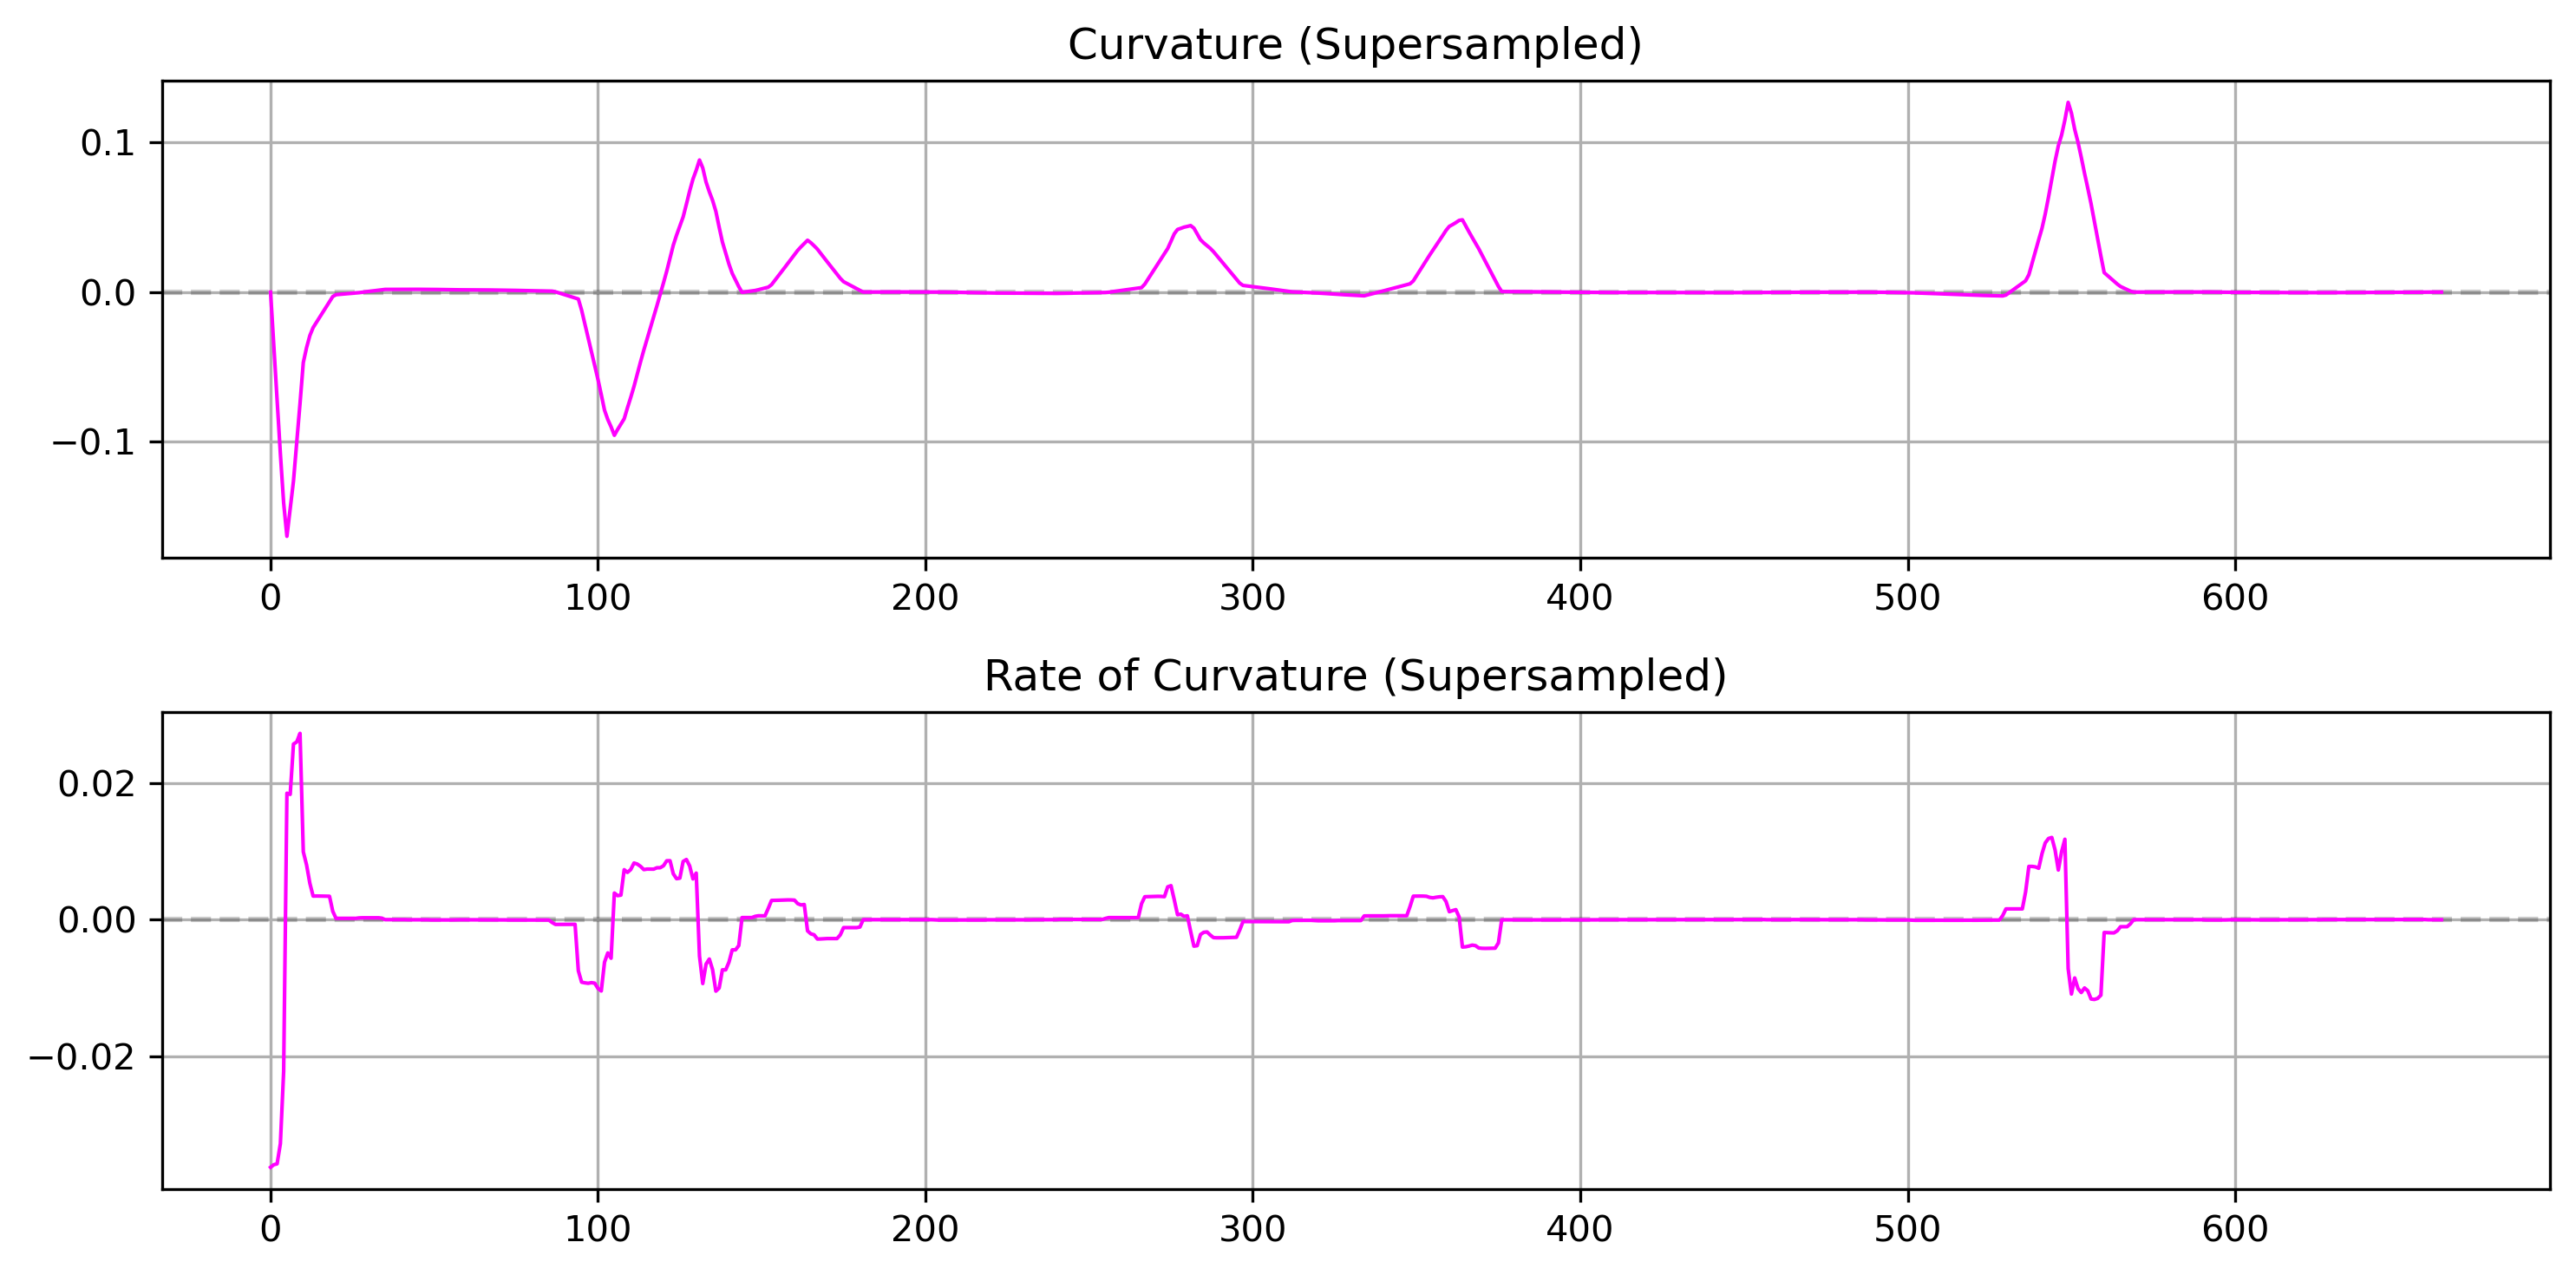

In [74]:
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(10, 5), dpi=300)

ax[0].set_title('Curvature (Supersampled)')
ax[0].axhline(0, linestyle='--', color='k', alpha=0.2)
ax[0].plot(ok, color='magenta', linewidth=1)
ax[0].grid()

ax[1].set_title('Rate of Curvature (Supersampled)')
ax[1].axhline(0, linestyle='--', color='k', alpha=0.2)
ax[1].plot(dok, color='magenta', linewidth=1)
ax[1].grid()

plt.tight_layout()
plt.show()

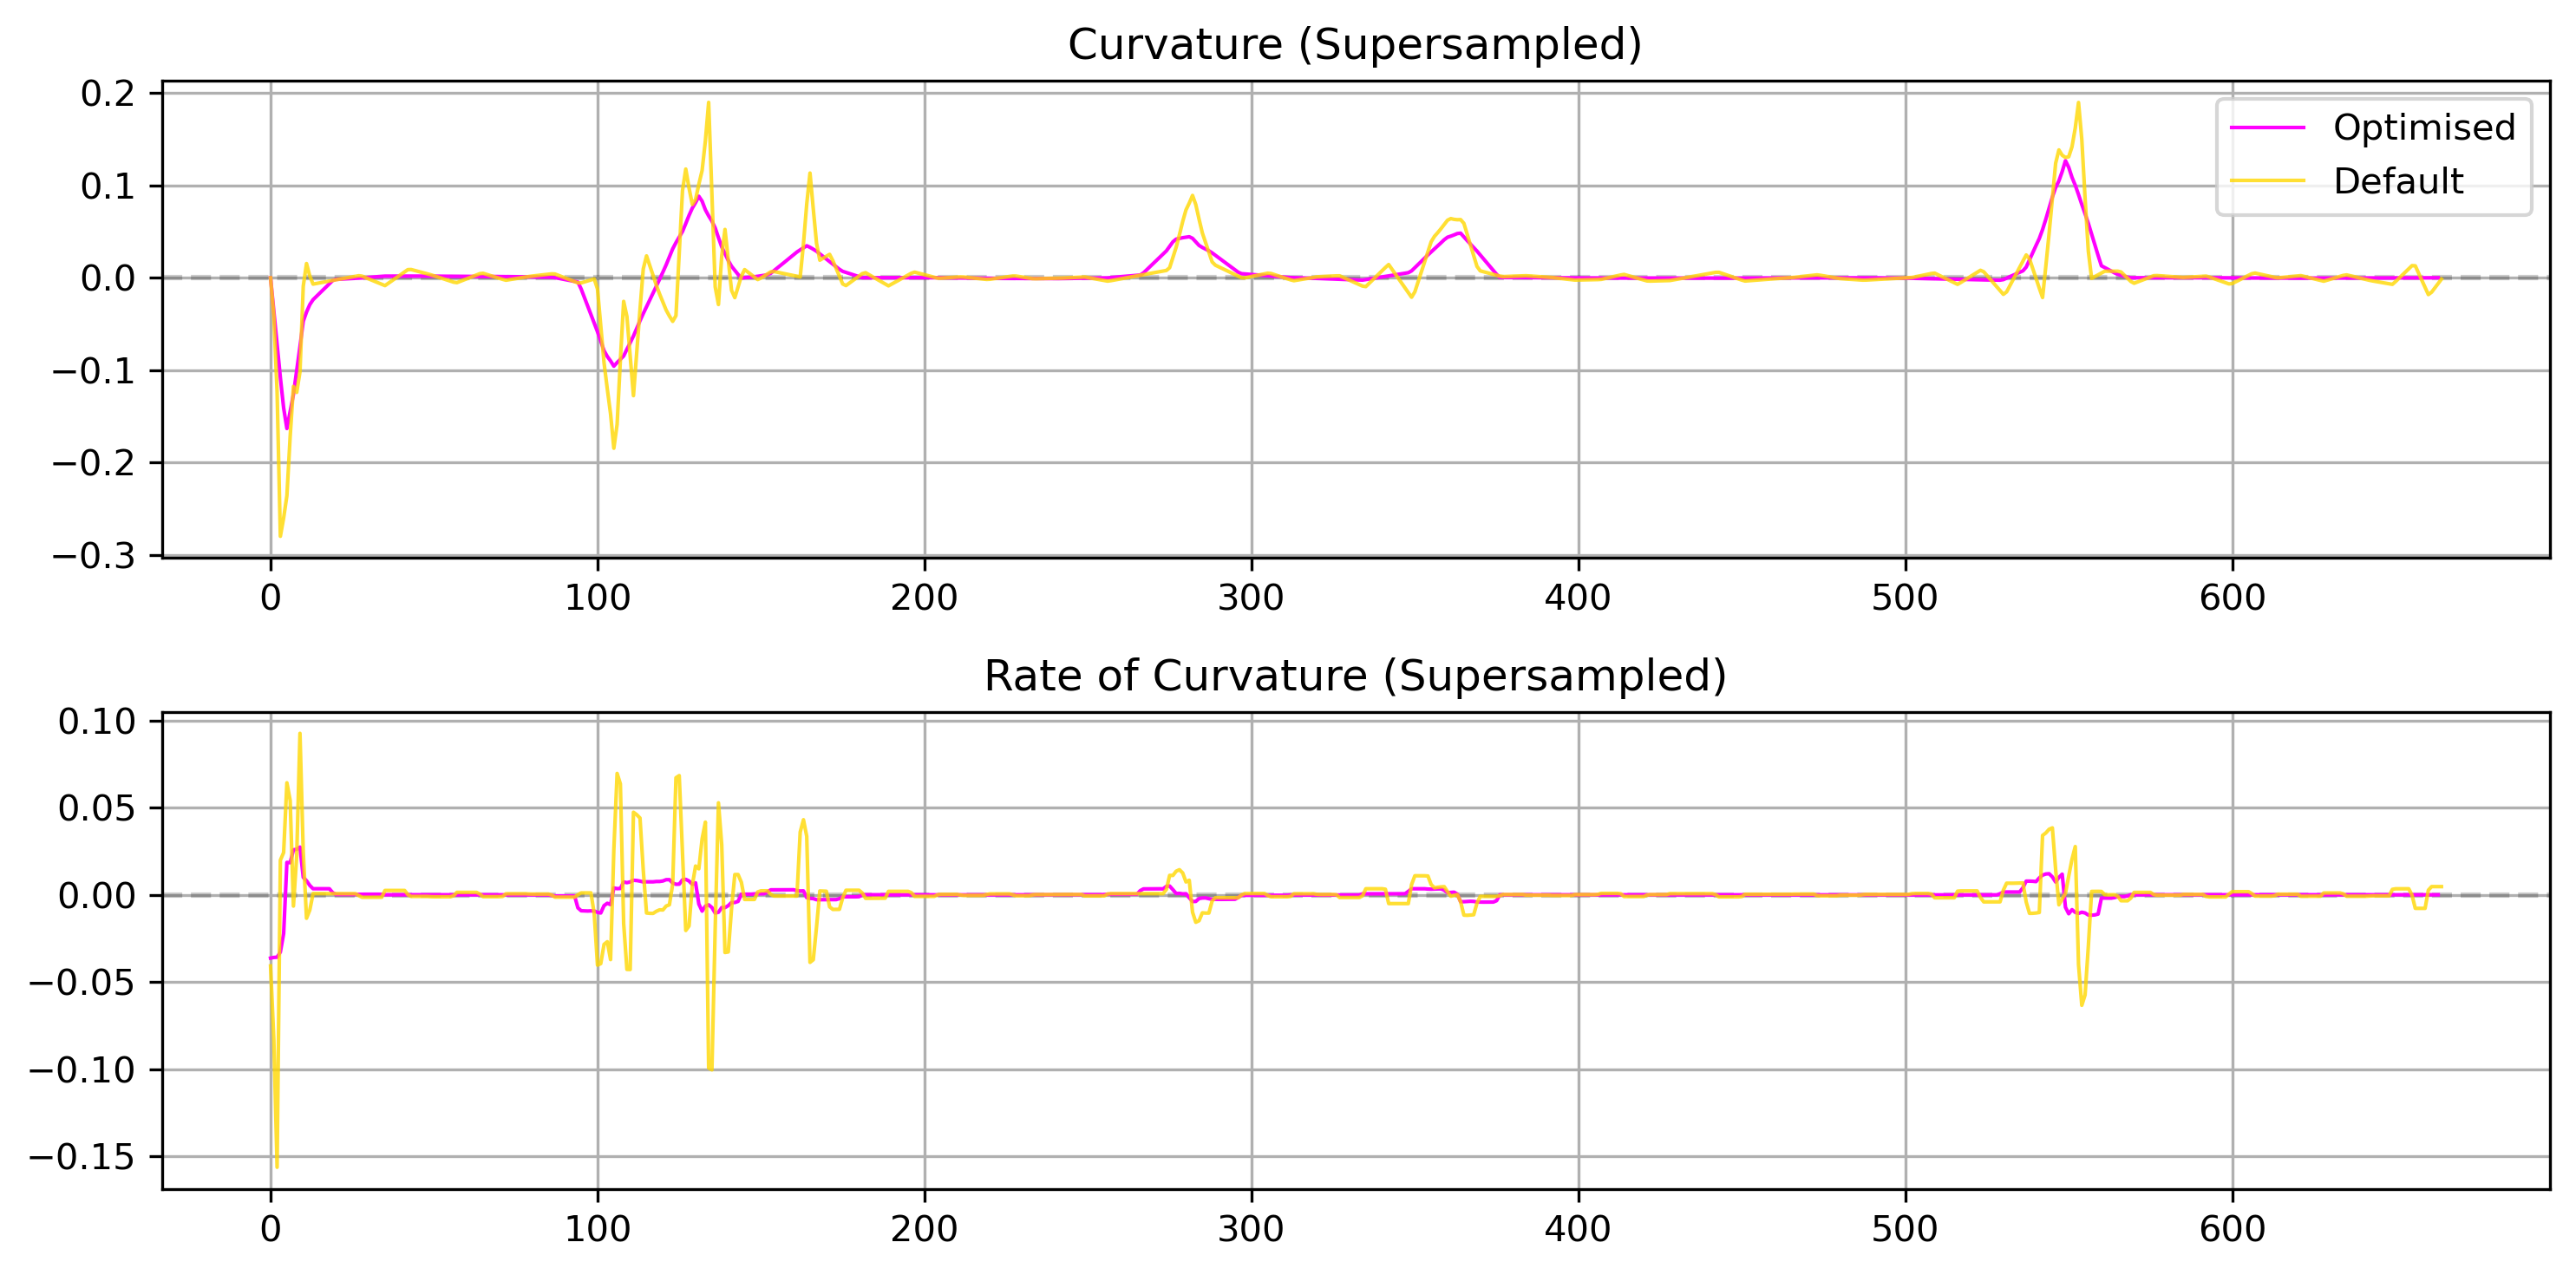

In [75]:
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(10, 5), dpi=300)

ax[0].set_title('Curvature (Supersampled)')
ax[0].axhline(0, linestyle='--', color='k', alpha=0.2)
ax[0].plot(ok, color='magenta', linewidth=1, label='Optimised')
ax[0].plot(ck, color='gold', linewidth=1, alpha=0.8, label='Default')
ax[0].legend()
ax[0].grid()

ax[1].set_title('Rate of Curvature (Supersampled)')
ax[1].axhline(0, linestyle='--', color='k', alpha=0.2)
ax[1].plot(dok, color='magenta', linewidth=1, label='Optimised')
ax[1].plot(dck, color='gold', linewidth=1, alpha=0.8, label='Default')
ax[1].grid()

plt.tight_layout()
plt.show()

### Remarks
Path curvature is extremely satisfactory.

In [76]:
axis = {'X-axis': ox, 'Y-axis': oy, 'Yaw': oyaw}
df = pd.DataFrame(axis, columns= ['X-axis', 'Y-axis', 'Yaw'])
df.to_csv("curb_solved.csv", index = False)